In [1]:
#modules and packages
import math
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats.distributions import chi2
BOLD = '\033[1m'
END = '\033[0m'
warnings.filterwarnings('ignore')

In [2]:
#methods for LLR test
def LLR_Test(mod_1, mod_2, DF=1, lags1=None,lags2=None):
    res1 = mod_1.fit(start_ar_lags=lags1)
    res2 = mod_2.fit(start_ar_lags=lags2)
    LR = 2*(res2.llf - res1.llf)
    val = 'P-Value for LLR: ' + str(chi2.sf(LR, DF).round(3))
    return val

#None nested ARMA model test
def LLR_ARMA_Nonest(mod_1, mod_2, DF=1, lags1=None,lags2=None):
    res1 = mod_1.fit(start_ar_lags=lags1)
    res2 = mod_2.fit(start_ar_lags=lags2)
    print('Higher Order Model Measures:')
    print('LL =', res2.llf, '\tAIC =', res2.aic)
    print('Lower Order Model Measures:')
    print('LL =', res1.llf, '\tAIC =', res1.aic)
    if res1.llf > res2.llf and res1.aic < res2.aic:
        print(BOLD+'Lower order model > Higher order model'+END)
    if res2.llf > res1.llf and res2.aic < res1.aic:
        print(BOLD+'Higher order model > Lower order model'+END)

#method for displaying ACF and PCF
def ACF_and_PACF(series, title):
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,6))
    sgt.plot_acf(series, lags = 40, zero=False, ax=ax1)
    sgt.plot_pacf(series, lags = 40, zero=False, method = 'ols', ax=ax2)
    ax1.title.set_text('ACF Plot for ' + title)
    ax1.title.set_size(20)
    ax2.title.set_size(20)
    ax2.title.set_text('PACF Plot for ' + title)
    plt.show()

In [3]:
#add and prepare dataset
raw = pd.read_csv('Index2018.csv')
data = raw.copy()

#date as index and set frequency
data.date = pd.to_datetime(data.date, dayfirst=True)
data.set_index('date', inplace=True)
data = data.asfreq('b')
data = data.fillna(method = 'ffill')

#we are isolating FTSE to use and create additional columns
data['market_value'] = data.ftse
del data['ftse']
data['returns'] = data.market_value.pct_change(1).mul(100)

#split into train and test
size = int(len(data)*0.8)
train = data.iloc[:size]
test = data.iloc[size:]

### Adjusting ARMA Models for Non-stationary Data
We use ARIMA models instead!!
It accounts for non-seasonal differences in the data that we need to examine to establish stationarity in the data. 
I = Integrated. That means the number of times you difference the series to make it stationary.

### Simple ARIMA(1,1,1) Model

In [4]:
model_ar1_1_ma1 = ARIMA(train.market_value, order=(1,1,1))
model_ar1_1_ma1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27603.666
Method:                       css-mle   S.D. of innovations             59.134
Date:                Sat, 11 Apr 2020   AIC                          55215.333
Time:                        18:03:59   BIC                          55241.418
Sample:                    01-10-1994   HQIC                         55224.473
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5657      0.682      0.829      0.407      -0.772       1.903
ar.L1.D.market_value     0.7475      0.070     10.652      0.000       0.610       0.885
ma.L1.D.market_value    -0.7936      0.064    -12.378      0.000      -0.919      -0.668
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3378           +0.0000j            1.3378            0.0000
MA.1            1.2601           +0.0000j            1.2601            0.0000
-----------------------------------------------------------------------------
"""

Note, all coefficients are significant. This shows the integrated series is closer to returns than prices. Now we want to examine residuals to see if we are missing any components

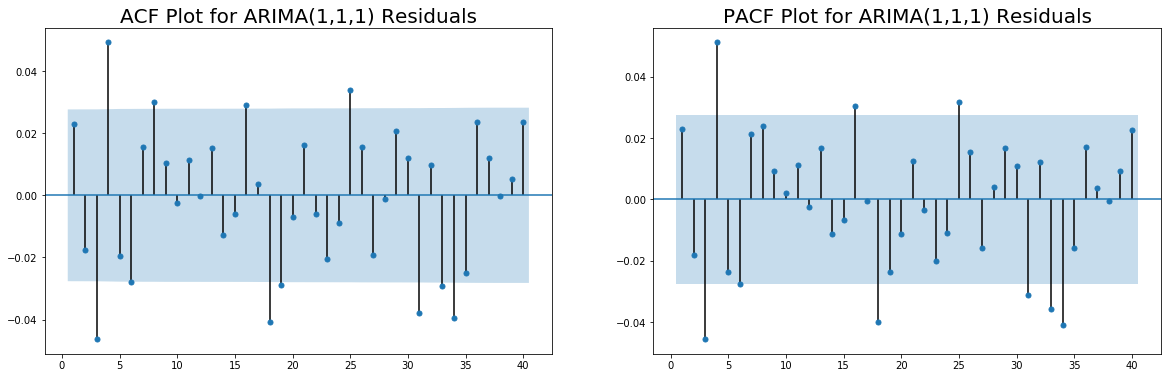

In [5]:
ACF_and_PACF(model_ar1_1_ma1.fit().resid, 'ARIMA(1,1,1) Residuals')

We see the third and forth lags are highly significant. From prior modeling, we found that the third and forth lags being included can significantly affect the optimality of our model. So let's examine higher order ARIMA models to see how we can improve this initial one. Adding up to 4 lags, there are only five models between ARIMA(1,1,1) and ARIMA(4,1,4) that had all significant coefficients

### Higher Order ARIMA Models
Models to explore from above because they have significant coefficients are:
- ARIMA(1,1,2), ARIMA(1,1,3), ARIMA(2,1,1), ARIMA(3,1,1), ARIMA(3,1,2)
- We need to define and fit these models so that we can compare their LL and AIC values to each other and that of the ARIMA(1,1,1) to determine the optimal one

In [6]:
#models
print('ARIMA(1,1,1) vs. ARIMA(1,1,2)')
model_ar1_1_ma2 = ARIMA(train.market_value, order=(1,1,2))
LLR_ARMA_Nonest(model_ar1_1_ma1, model_ar1_1_ma2)
print()
print('ARIMA(1,1,1) vs. ARIMA(1,1,3)')
model_ar1_1_ma3 = ARIMA(train.market_value, order=(1,1,3))
LLR_ARMA_Nonest(model_ar1_1_ma1, model_ar1_1_ma3)
print()
print('ARIMA(1,1,1) vs. ARIMA(2,1,1)')
model_ar2_1_ma1 = ARIMA(train.market_value, order=(2,1,1))
LLR_ARMA_Nonest(model_ar1_1_ma1, model_ar2_1_ma1)
print()
print('ARIMA(1,1,1) vs. ARIMA(3,1,1)')
model_ar3_1_ma1 = ARIMA(train.market_value, order=(3,1,1))
LLR_ARMA_Nonest(model_ar1_1_ma1, model_ar3_1_ma1)
print()
print('ARIMA(1,1,1) vs. ARIMA(3,1,2)')
model_ar3_1_ma2 = ARIMA(train.market_value, order=(3,1,2))
LLR_ARMA_Nonest(model_ar1_1_ma1, model_ar3_1_ma2, lags2=5)

ARIMA(1,1,1) vs. ARIMA(1,1,2)
Higher Order Model Measures:
LL = -27600.08186312018 	AIC = 55210.16372624036
Lower Order Model Measures:
LL = -27603.666412801424 	AIC = 55215.33282560285
Higher order model > Lower order model

ARIMA(1,1,1) vs. ARIMA(1,1,3)
Higher Order Model Measures:
LL = -27590.424032560222 	AIC = 55192.848065120445
Lower Order Model Measures:
LL = -27603.666412801424 	AIC = 55215.33282560285
Higher order model > Lower order model

ARIMA(1,1,1) vs. ARIMA(2,1,1)
Higher Order Model Measures:
LL = -27599.807487847476 	AIC = 55209.61497569495
Lower Order Model Measures:
LL = -27603.666412801424 	AIC = 55215.33282560285
Higher order model > Lower order model

ARIMA(1,1,1) vs. ARIMA(3,1,1)
Higher Order Model Measures:
LL = -27592.055371698458 	AIC = 55196.110743396915
Lower Order Model Measures:
LL = -27603.666412801424 	AIC = 55215.33282560285
Higher order model > Lower order model

ARIMA(1,1,1) vs. ARIMA(3,1,2)
Higher Order Model Measures:
LL = -27590.66080897039 	AIC = 5

From the above, the ARIMA(1,1,3) has the lowest AIC and highest LL of all the winning models. Given this, it becomes our frontrunner for the optimal model. We however note that it is nested with the ARIMA(1,1,1) and ARIMA(1,1,2) models, so we need to run the LLR test to make sure it significantly outperforms them if it is going to stand as the optimal model.

In [7]:
LLR_Test(model_ar1_1_ma2,model_ar1_1_ma3)

'P-Value for LLR: 0.0'

In [8]:
LLR_Test(model_ar1_1_ma1,model_ar1_1_ma3)

'P-Value for LLR: 0.0'

The ARIMA(1,1,3) passes the test and for now is our optimal model. We then go back to the residuals to see if we can improve this model further.

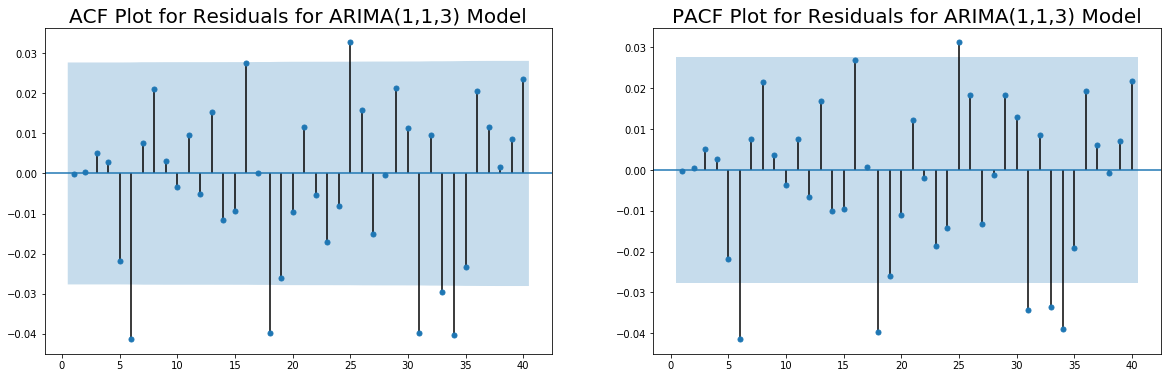

In [9]:
ACF_and_PACF(model_ar1_1_ma3.fit().resid, 'Residuals for ARIMA(1,1,3) Model')

ACF Review: Fewer lags have significance, but the sixth lag is significant and so we want to see if there is another model that is better between ARIMA(1,1,1) and ARIMA(6,1,6). After going through these models, you should find that the only ones with all significant coefficients are ARIMA(6,1,3) and ARIMA(5,1,1). We then compute these and compare them to the ARIMA(1,1,3) that was previously chosen as our optimal model.

In [10]:
def display_comps(mod1, name1):
    print(name1, 'LL=', mod1.fit().llf, '\tAIC=', mod1.fit().aic)

In [11]:
#models
model_ar1_1_ma3 = ARIMA(train.market_value, order=(1,1,3))
model_ar5_1_ma1 = ARIMA(train.market_value, order=(5,1,1))
model_ar6_1_ma3 = ARIMA(train.market_value, order=(6,1,3))

#Show measures
display_comps(model_ar1_1_ma3, 'ARIMA(1,1,3) Model:')
display_comps(model_ar5_1_ma1, 'ARIMA(5,1,1) Model:')
display_comps(model_ar6_1_ma3, 'ARIMA(6,1,3) Model:')

ARIMA(1,1,3) Model: LL= -27590.424032560222 	AIC= 55192.848065120445
ARIMA(5,1,1) Model: LL= -27586.511888122284 	AIC= 55189.02377624457
ARIMA(6,1,3) Model: LL= -27581.45547815983 	AIC= 55184.91095631966


In [12]:
#Nested model = LLR test
print('ARIMA(1,1,3) vs. ARIMA(6,1,3):', LLR_Test(model_ar1_1_ma3, model_ar6_1_ma3, DF=5, lags2=11))
#didnt get an error so I dont know why we use 11 start lags. Same as below

ARIMA(1,1,3) vs. ARIMA(6,1,3): P-Value for LLR: 0.018


In [13]:
#Nested model = LLR test
print('ARIMA(5,1,1) vs. ARIMA(6,1,3):', LLR_Test(model_ar5_1_ma1, model_ar6_1_ma3, DF=3))

ARIMA(5,1,1) vs. ARIMA(6,1,3): P-Value for LLR: 0.018


In [14]:
#No nested model here = No nested test
print('ARIMA(1,1,3) vs. ARIMA(5,1,1):')
LLR_ARMA_Nonest(model_ar1_1_ma3, model_ar5_1_ma1)

ARIMA(1,1,3) vs. ARIMA(5,1,1):
Higher Order Model Measures:
LL = -27586.511888122284 	AIC = 55189.02377624457
Lower Order Model Measures:
LL = -27590.424032560222 	AIC = 55192.848065120445
Higher order model > Lower order model


So we learn that ARIMA(6,1,3) > ARIMA(5,1,1) > ARIMA(1,1,3) when we just look at LL and AIC. However, we can use the LLR to compare the higher order model to the other two. When this happens, the LLR test says that ARIMA(6,1,3) model does not significantly yield a higher likelihood compared to the ARIMA(5,1,1) model. Given this, **our new optimal is the ARIMA(5,1,1) model**.

In [15]:
model_ar5_1_ma1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -27586.512
Method:                       css-mle   S.D. of innovations             58.932
Date:                Sat, 11 Apr 2020   AIC                          55189.024
Time:                        18:06:07   BIC                          55241.193
Sample:                    01-10-1994   HQIC                         55207.305
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5661      0.690      0.820      0.412      -0.787       1.919
ar.L1.D.market_value     0.4011      0.159      2.529      0.011       0.090       0.712
ar.L2.D.market_value    -0.0445      0.016     -2.856      0.004      -0.075      -0.014
ar.L3.D.market_value    -0.0543      0.017     -3.163      0.002      -0.088      -0.021
ar.L4.D.market_value     0.0586      0.019      3.069      0.002       0.021       0.096
ar.L5.D.market_value    -0.0581      0.014     -4.118      0.000      -0.086      -0.030
ma.L1.D.market_value    -0.4213      0.158     -2.659      0.008      -0.732      -0.111
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.7609           -0.0000j            1.7609           -0.5000
AR.2            1.4633           -0.8605j            1.6975           -0.0846
AR.3            1.4633           +0.8605j            1.6975            0.0846
AR.4           -0.0790           -1.8393j            1.8410           -0.2568
AR.5           -0.0790           +1.8393j            1.8410            0.2568
MA.1            2.3734           +0.0000j            2.3734            0.0000
-----------------------------------------------------------------------------
"""

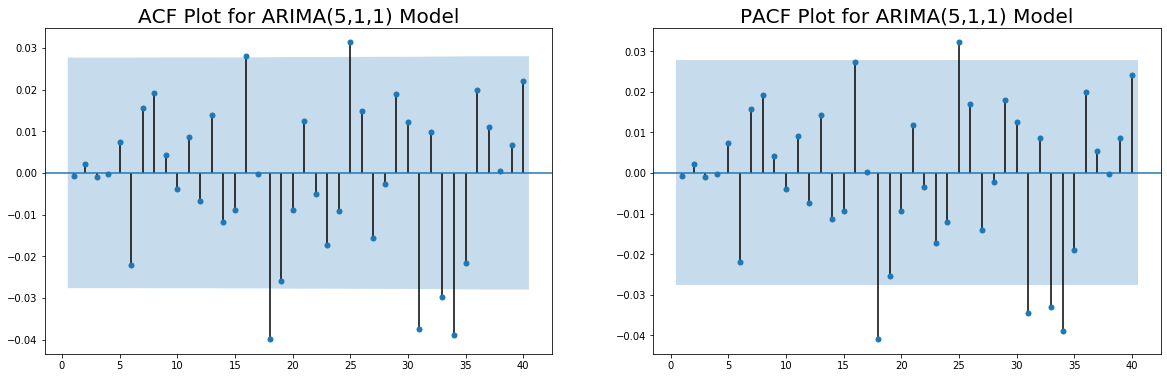

In [16]:
ACF_and_PACF(model_ar5_1_ma1.fit().resid, 'ARIMA(5,1,1) Model')

Although there are other lags which are significant up to the 35th lag, most of the initial ones are insignificant and randomly appearing. Because we want to avoid overfitting, we don't want to have a 35 lag model because we should be able to use this model on other data.

### Models with Higher Levels of Integration
Note: we only rely on integration to make data stationary. So if our series becomes stationary, we dont need to integrate further. Example below comparing differenced series ADF test vs. no differencing

In [17]:
train['delta_prices'] = train.market_value.diff(1)

In [18]:
model_d_ar1_1_ma1 = ARIMA(train.delta_prices[1:], order=(1,0,1))
sts.adfuller(train.delta_prices[1:])

(-32.24409349570747,
 0.0,
 5,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54845.96104221891)

Looks like from the p-value above, the series is stationary so we dont intergrate further! We avoid using ARIMA models with stationary data because:
- It is computationally expensive => the more layers, the more the machine has to work before fitting the data
- More differencing => losing data points which causes our model to suffer
- The more differencing, the smaller the margin of error => the harder it is to fit an accurate model which causes numerical instability with computations
- The more layers we add, the harder it is to interpret the results. The simpler the better to extract useful insights

## AR(I)MAX Models
ARIMA/ARMA models where we have an additional variable of interest which is exogenous. It is denoted by X and also has a coefficient within the model. It can stand for one variable or a collection of variables that affect the time series observation of interest. To be included in the model, the variable has to be of interest as it pertains to the time series AND must be available for all time periods observed.
- Python method to show this is by adding exog (Array of values) to the ARMA/ARIMA model argument

In [19]:
#ARIMAX with spx
model_ar1_1_ma1_Xspx = ARIMA(train.market_value, exog = train.spx, order=(1,1,1))
model_ar1_1_ma1_Xspx.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27603.556
Method:                       css-mle   S.D. of innovations             59.132
Date:                Sat, 11 Apr 2020   AIC                          55217.112
Time:                        18:06:15   BIC                          55249.718
Sample:                    01-10-1994   HQIC                         55228.538
                         - 04-05-2013                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.5868      2.655     -0.221      0.825      -5.791       4.618
spx                      0.0011      0.002      0.450      0.652      -0.004       0.006
ar.L1.D.market_value     0.7456      0.070     10.577      0.000       0.607       0.884
ma.L1.D.market_value    -0.7916      0.065    -12.272      0.000      -0.918      -0.665
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3412           +0.0000j            1.3412            0.0000
MA.1            1.2632           +0.0000j            1.2632            0.0000
-----------------------------------------------------------------------------
"""

## Seasonal Model - SAR(I)MA(X) Model
Seasonally adjusted ARMA, ARIMA, ARIMAX models
ARIMAX(p,d,q)
SARIMAX(p,d,q)(P,D,Q,s)  
where s = the number of seasons/periods needed to pass before the tendency reappears. E.g. 12 months/1 year need to pass each year for Christmas to reappear. If s=1, then there is no seasonality because 1/1 periods pass before the tendency reappears

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [21]:
#SARIMAX(1,0,1)(2,0,1,5),X=spx
model_sarimax = SARIMAX(train.market_value, exog = train.spx, order=(1,0,1), seasonal_order=(2,0,1,5))
model_sarimax.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                      market_value   No. Observations:                 5021
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 5)   Log Likelihood              -26712.819
Date:                           Sat, 11 Apr 2020   AIC                          53439.637
Time:                                   18:06:46   BIC                          53485.287
Sample:                               01-07-1994   HQIC                         53455.633
                                    - 04-05-2013                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            2.7026      0.035     76.264      0.000       2.633       2.772
ar.L1          0.9998      0.001   1880.773      0.000       0.999       1.001
ma.L1         -0.3099      0.010    -32.582      0.000      -0.329      -0.291
ar.S.L5        0.9651      0.011     87.146      0.000       0.943       0.987
ar.S.L10       0.0344      0.010      3.322      0.001       0.014       0.055
ma.S.L5       -0.9984      0.005   -190.360      0.000      -1.009      -0.988
sigma2      2442.4865     28.586     85.443      0.000    2386.459    2498.514
===================================================================================
Ljung-Box (Q):                       95.41   Jarque-Bera (JB):              4213.92
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Homework: 
FIT SARMAX/SARIMAX/SARIMA models with different series (spx, dax, nikkei) and examin/interpret coefficients